# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
Subset of a non-diabetic slide (fov == 12) 

### Pre-requisites

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-05-15 23:29:06.474727: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 23:29:10.822879: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 23:29:17.699993: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 23:29:39.760106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nc.__version__

'0.1.5'

### Load data

In [3]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
file   = 'imputed_envi.h5ad'
adata = sc.read(filename = folder + file)
adata

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 5208 × 5000
    obs: 'fov', 'cell_ID', 'cell_type_coarse'
    uns: 'cell_type_coarse_colors', 'spatial'
    obsm: 'spatial'

In [4]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


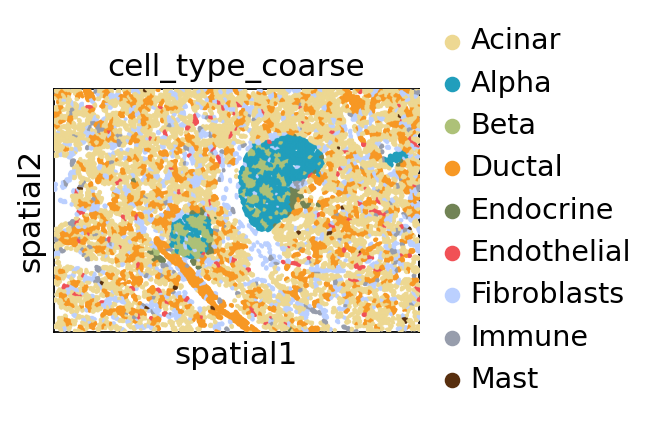

In [5]:
sq.pl.spatial_segment(adata,color='cell_type_coarse',ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [6]:
from matplotlib.pyplot import rc_context

In [6]:
HORMONES = ['INS','GCG','SST']
adata.uns['cell_type_coarse_colors'] = ['#00bbf9', '#a7c957', '#F4BA41', '#e63946', '#6c757d', '#ffcdb2','#fb8500']

In [ ]:
# Check expression of known markers to get intuition of the dataset
with rc_context({'figure.figsize': (10.5,7)}):
    sc.pl.embedding(
        adata,
        basis='spatial',
        color=HORMONES,
        vmin=0,
        vmax='p99',  
        sort_order=False,  
        frameon=False,
        cmap='RdYlBu_r', 
        size=150,ncols=3
    )

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar
Alpha
Beta
Ductal
Endocrine
Endothelial
Fibroblasts
Immune
Mast


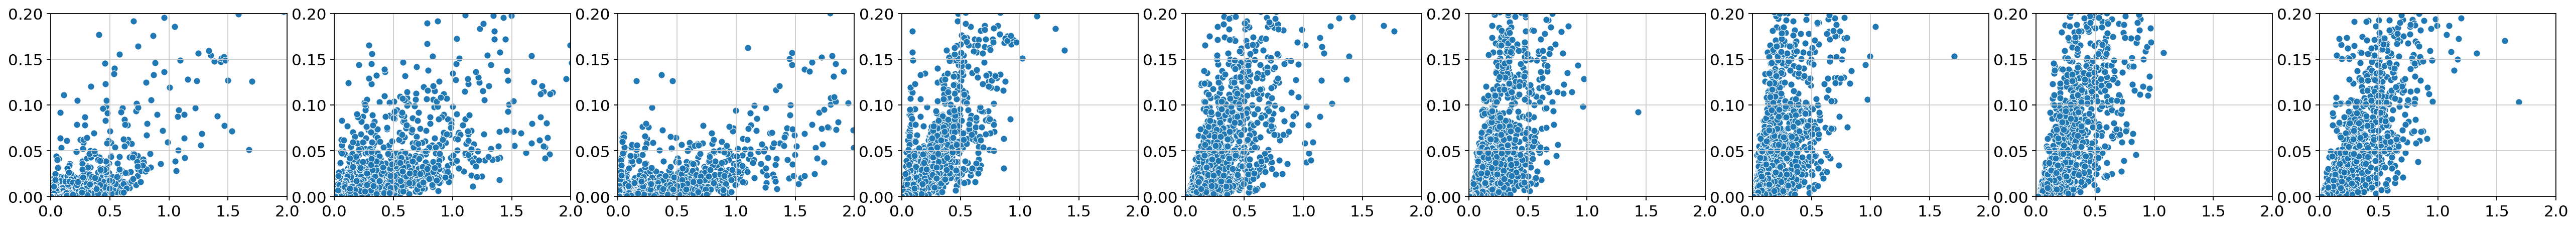

In [8]:
fig, ax = plt.subplots(1,len(np.unique(adata.obs['cell_type_coarse'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata.obs['cell_type_coarse'])):
    print(ct)
    mean = np.mean(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    var = np.var(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

In [9]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

### Pre-processing

In [10]:
# the data seems not normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

array([[1.2735046e-02, 6.8773241e-03, 1.9812395e-04, ..., 2.4451101e-03,
        2.7597271e-04, 3.7720305e-01],
       [6.0811341e-03, 1.1726904e-02, 1.1812144e-04, ..., 1.8480865e-03,
        4.5685854e-05, 6.4248264e-01],
       [1.1028943e-02, 5.6234533e-03, 1.6680426e-03, ..., 7.8698091e-04,
        1.4548172e-03, 1.2026611e-01],
       ...,
       [1.4815997e-02, 6.8833060e-03, 2.7466286e-04, ..., 2.6658783e-03,
        3.8410979e-04, 3.3028924e-01],
       [1.2242572e-02, 6.9871442e-03, 1.9123359e-04, ..., 2.3687531e-03,
        2.5324774e-04, 3.8591284e-01],
       [9.6563343e-03, 6.6295834e-03, 1.2975978e-04, ..., 2.3574815e-03,
        2.0408472e-04, 4.5082399e-01]], dtype=float32)

In [11]:
# calculating node degree for several distances 
for rd in [0,35,50,110,180,500]:
    connectivities, _ = sq.gr.spatial_neighbors(
        adata, radius=rd, coord_type='generic', copy=True
    )
    print(np.mean(np.sum(connectivities, axis=0)))

0.0
0.23732718894009217
1.2645929339477726
9.872119815668203
26.92089093701997
192.69009216589862


In [83]:
sq.gr.spatial_neighbors

<function squidpy.gr._build.spatial_neighbors(adata: 'AnnData | SpatialData', spatial_key: 'str' = 'spatial', library_key: 'str | None' = None, coord_type: 'str | CoordType | None' = None, n_neighs: 'int' = 6, radius: 'float | tuple[float, float] | None' = None, delaunay: 'bool' = False, n_rings: 'int' = 1, percentile: 'float | None' = None, transform: 'str | Transform | None' = None, set_diag: 'bool' = False, key_added: 'str' = 'spatial', copy: 'bool' = False) -> 'tuple[csr_matrix, csr_matrix] | None'>

In [86]:
sq.gr.spatial_neighbors(
    adata,
    n_neighs=15,
    coord_type="generic",
    delaunay=True,
)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:27: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


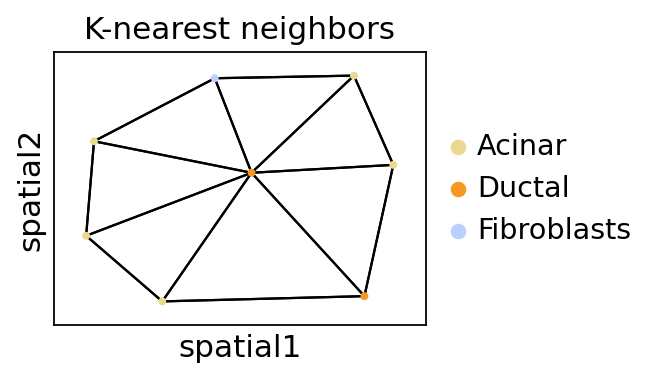

In [87]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx,420],
    library_id = '12',
    color="cell_type_coarse",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

In [88]:
sq.gr.nhood_enrichment(adata,cluster_key='cell_type_coarse')

100%|██████████| 1000/1000 [00:01<00:00, 841.79/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


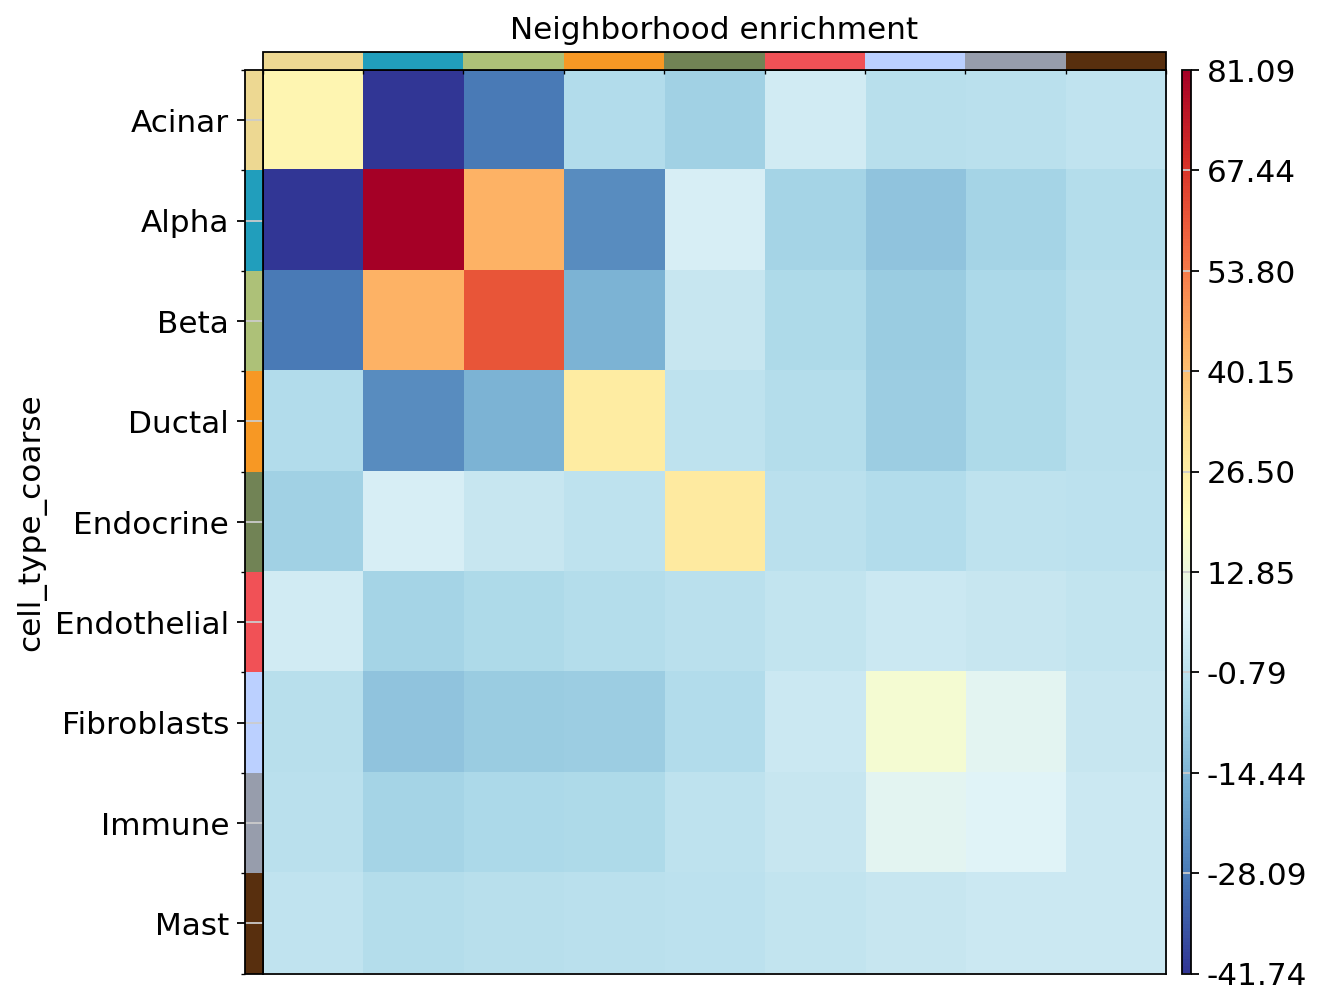

In [89]:
sq.pl.nhood_enrichment(adata, cluster_key='cell_type_coarse',cmap='RdYlBu_r')

In [90]:
sq.gr.interaction_matrix(adata, cluster_key='cell_type_coarse',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


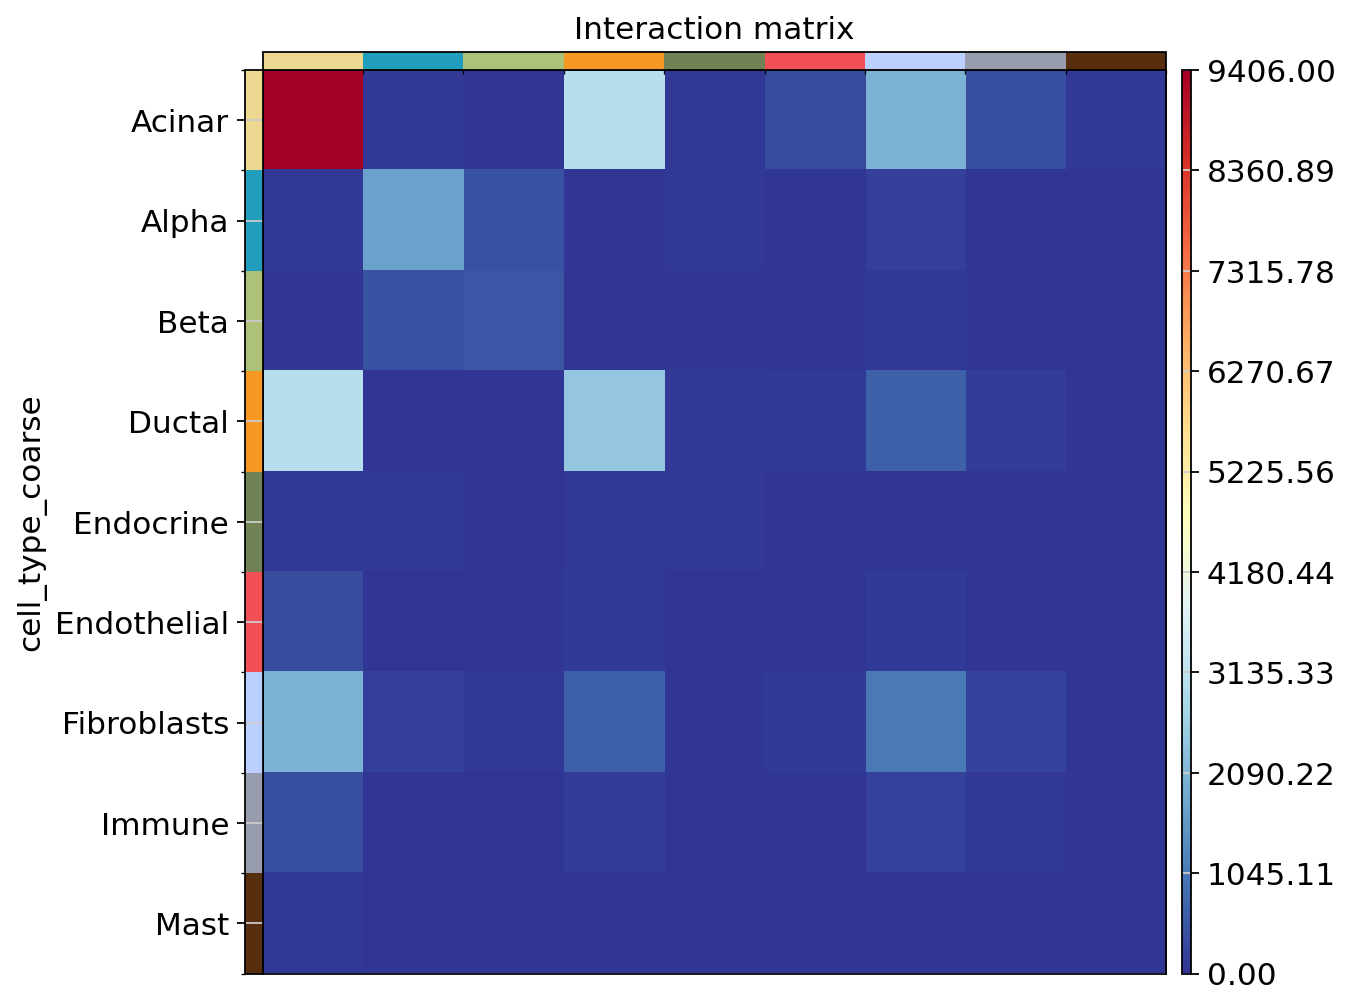

In [91]:
sq.pl.interaction_matrix(adata, cluster_key='cell_type_coarse',cmap='RdYlBu_r')

In [18]:
sq.gr.ligrec(adata,cluster_key='cell_type_coarse',use_raw=False)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
14.2MB [00:00, 52.7MB/s]
1.64MB [00:00, 25.5MB/s]
3.94MB [00:00, 48.7MB/s]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:06<00:00, 166.28permutation/s]


In [21]:
sq.pl.ligrec

<function squidpy.pl._ligrec.ligrec(adata: 'AnnData | Mapping[str, pd.DataFrame]', cluster_key: 'str | None' = None, source_groups: 'str | Sequence[str] | None' = None, target_groups: 'str | Sequence[str] | None' = None, means_range: 'tuple[float, float]' = (-inf, inf), pvalue_threshold: 'float' = 1.0, remove_empty_interactions: 'bool' = True, remove_nonsig_interactions: 'bool' = False, dendrogram: 'str | None' = None, alpha: 'float | None' = 0.001, swap_axes: 'bool' = False, title: 'str | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'int | None' = None, save: 'str | Path | None' = None, **kwargs: 'Any') -> 'None'>

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:121: UserWarning: Over 500 categories found. Plot would be very large.
  warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


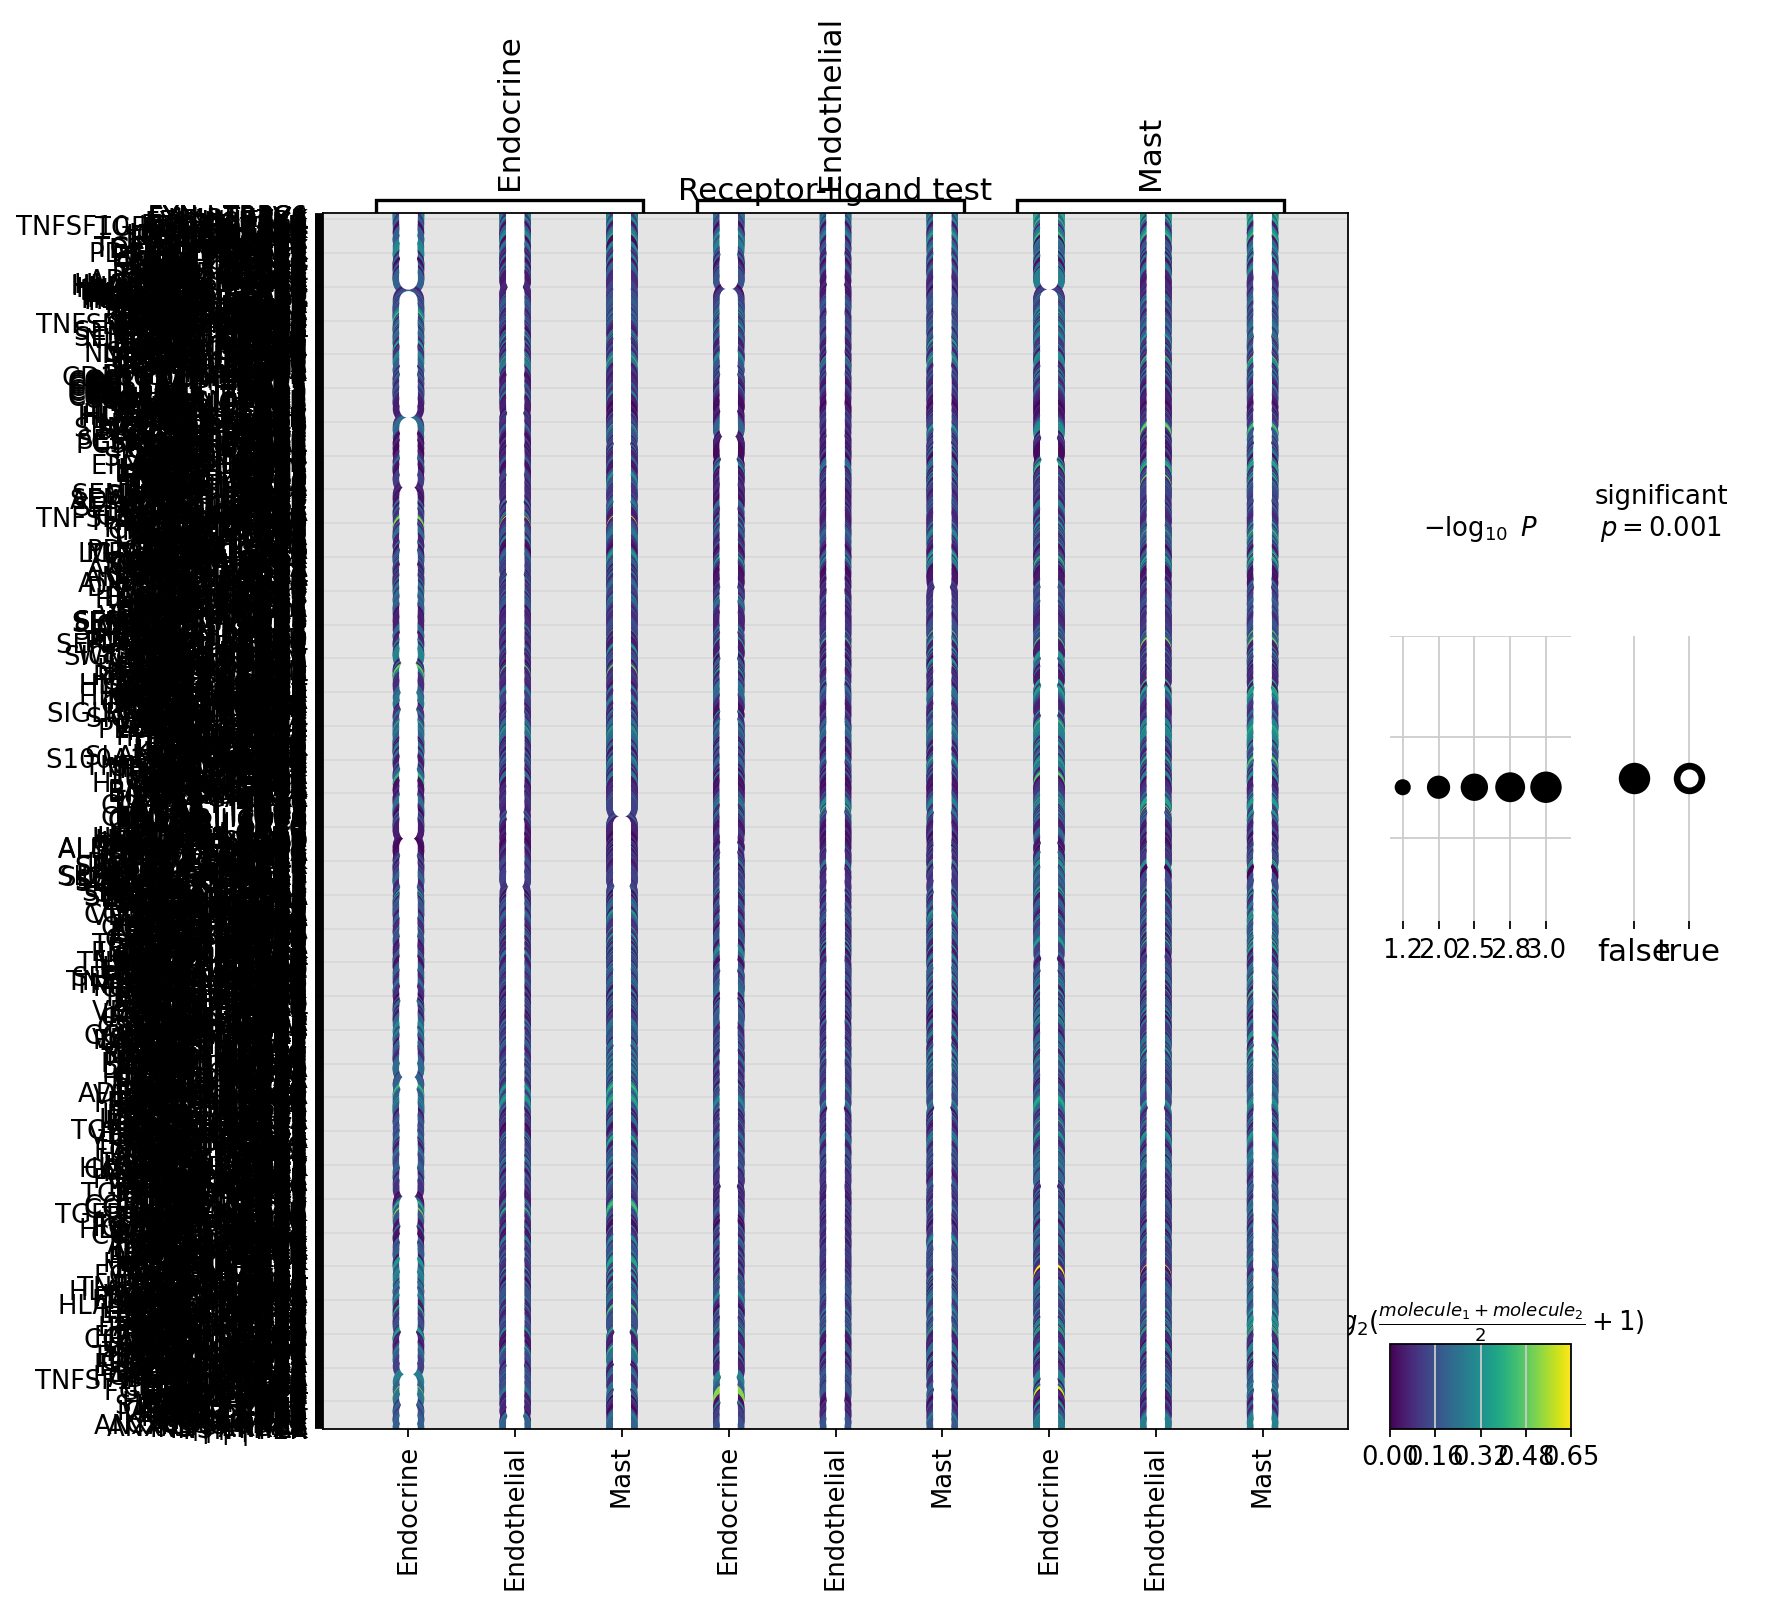

In [22]:
sq.pl.ligrec(adata, cluster_key='cell_type_coarse',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

### NCEM

In [23]:
from ncem.tl.fit.glm import linear_ncem

In [82]:
linear_ncem

<function ncem.tl.fit.backend.linear_model.linear_ncem(adata: anndata._core.anndata.AnnData, key_type: str, key_graph: str, formula: str = '~0', type_specific_confounders: List[str] = [])>

In [24]:
adata = linear_ncem(adata=adata, key_type='cell_type_coarse', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [25]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

In [26]:
adata

AnnData object with n_obs × n_vars = 5208 × 5000
    obs: 'fov', 'cell_ID', 'cell_type_coarse'
    uns: 'cell_type_coarse_colors', 'spatial', 'log1p', 'spatial_neighbors', 'cell_type_coarse_nhood_enrichment', 'cell_type_coarse_interactions', 'cell_type_coarse_ligrec', 'ncem'
    obsm: 'spatial', 'ncem_niche', 'ncem_dmat'
    varm: 'ncem_params', 'ncem_tested_params', 'ncem_pvals', 'ncem_fdr_pvals'
    obsp: 'spatial_connectivities', 'spatial_distances'

### Exploring interesting interactions

In [96]:
!pip install sanbomics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:0000:0100:01


In [97]:
from sanbomics.plots import volcano

In [98]:
volcano

<function sanbomics.plots.volcano(data, log2fc='log2FoldChange', pvalue='padj', symbol='symbol', baseMean=None, pval_thresh=0.05, log2fc_thresh=0.75, to_label=5, color_dict=None, shape_dict=None, fontsize=10, colors=['dimgrey', 'lightgrey', 'black'], top_right_frame=False, figsize=(5, 5), legend_pos=(1.4, 1), point_sizes=(15, 150), save=False, shapes=None, shape_order=None)>

In [93]:
interactions = [
    'index_Endocrine:neighbor_Ductal',
    'index_Ductal:neighbor_Endocrine',
    'index_Acinar:neighbor_Ductal',
    'index_Ductal:neighbor_Acinar',
]

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


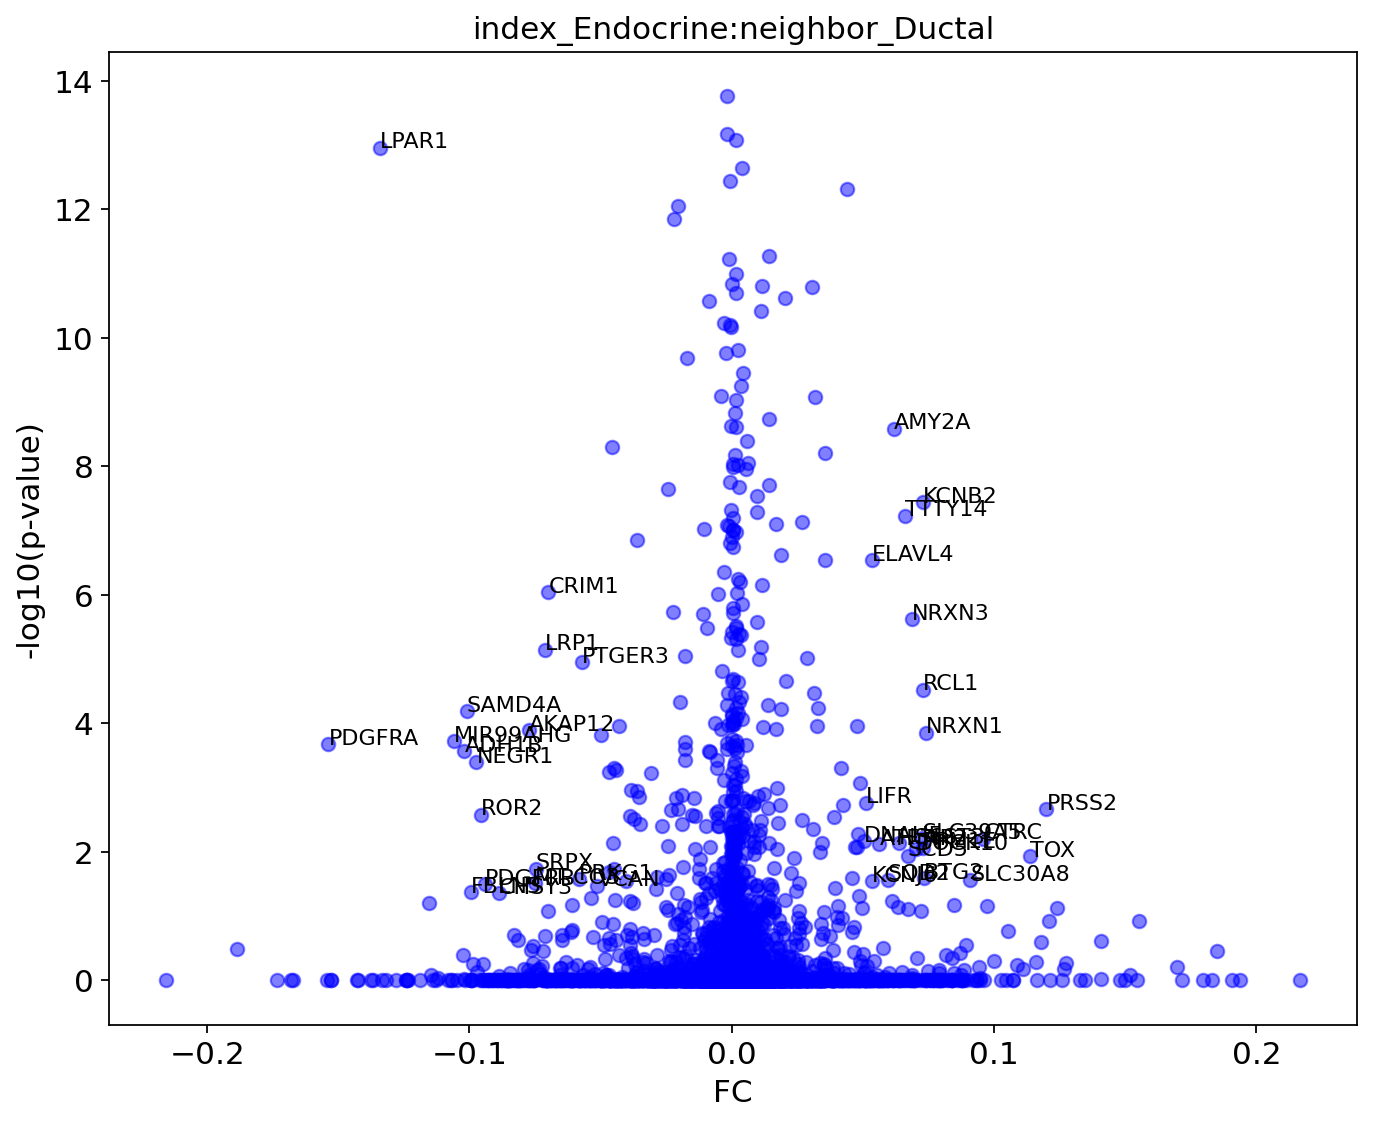

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


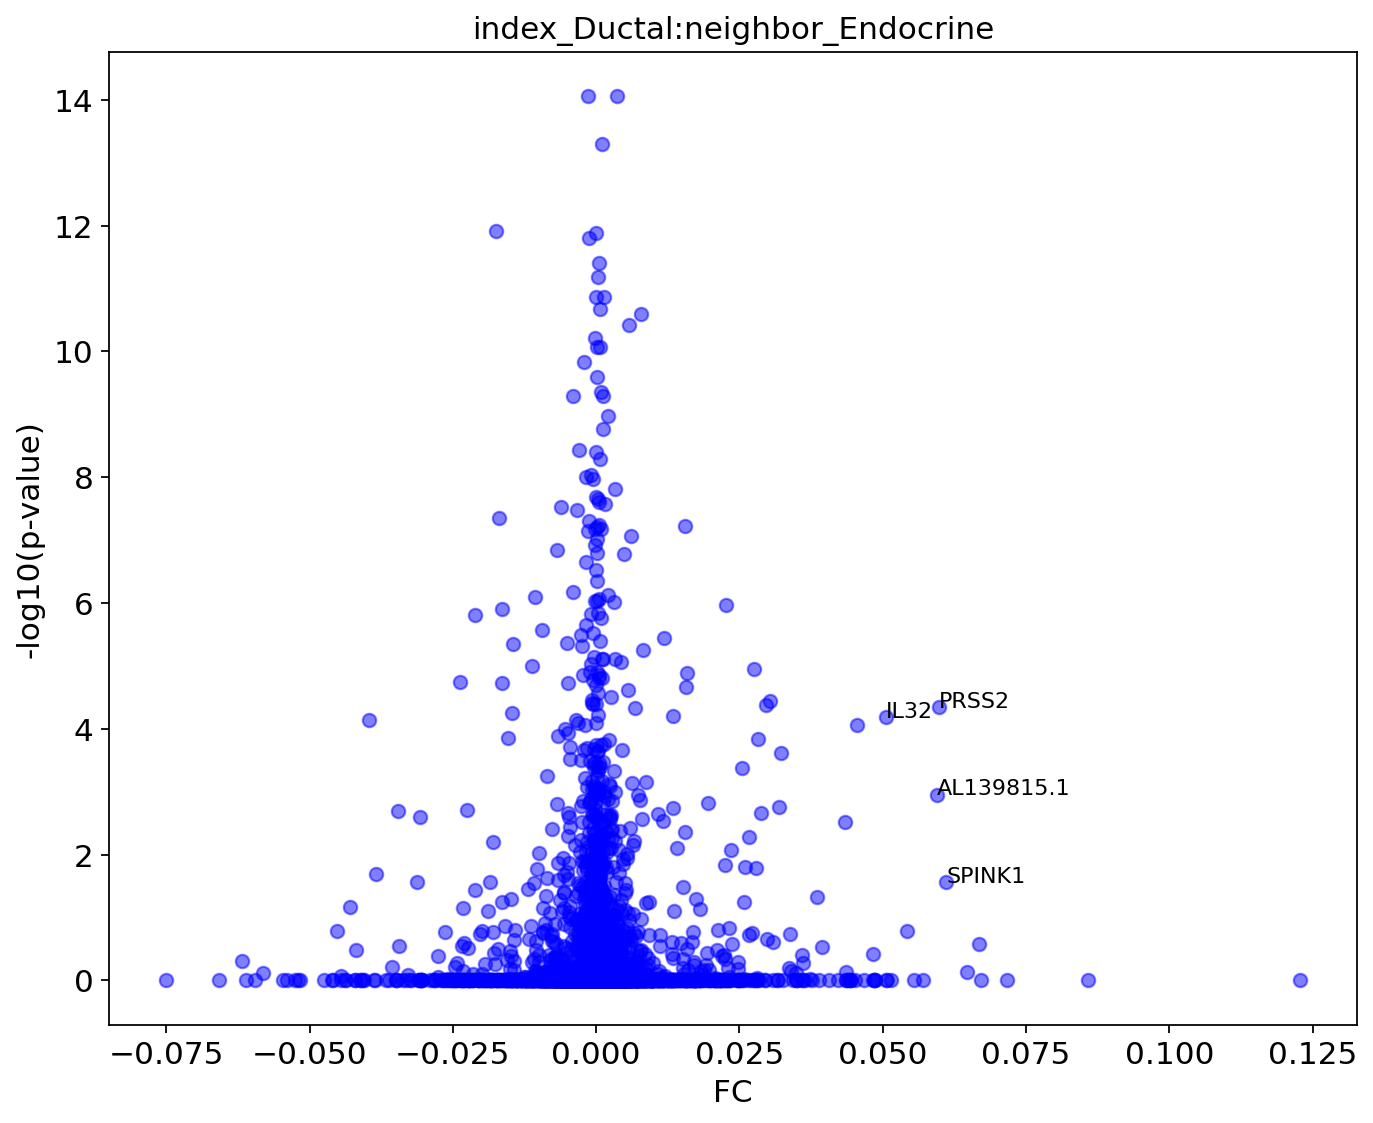

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


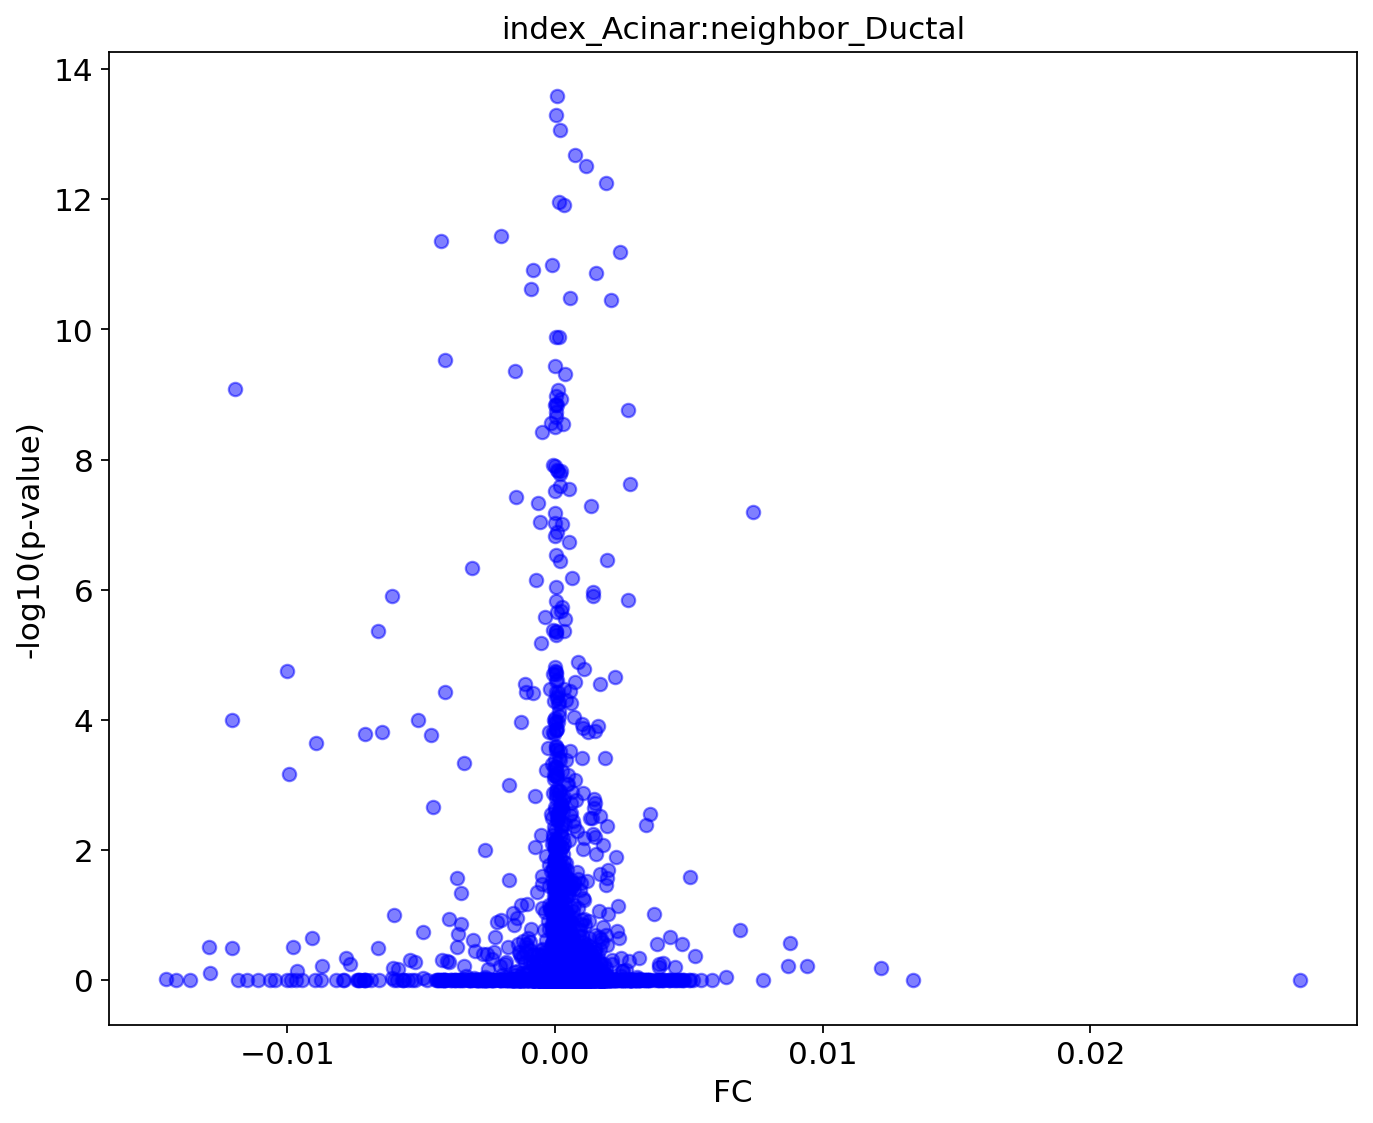

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


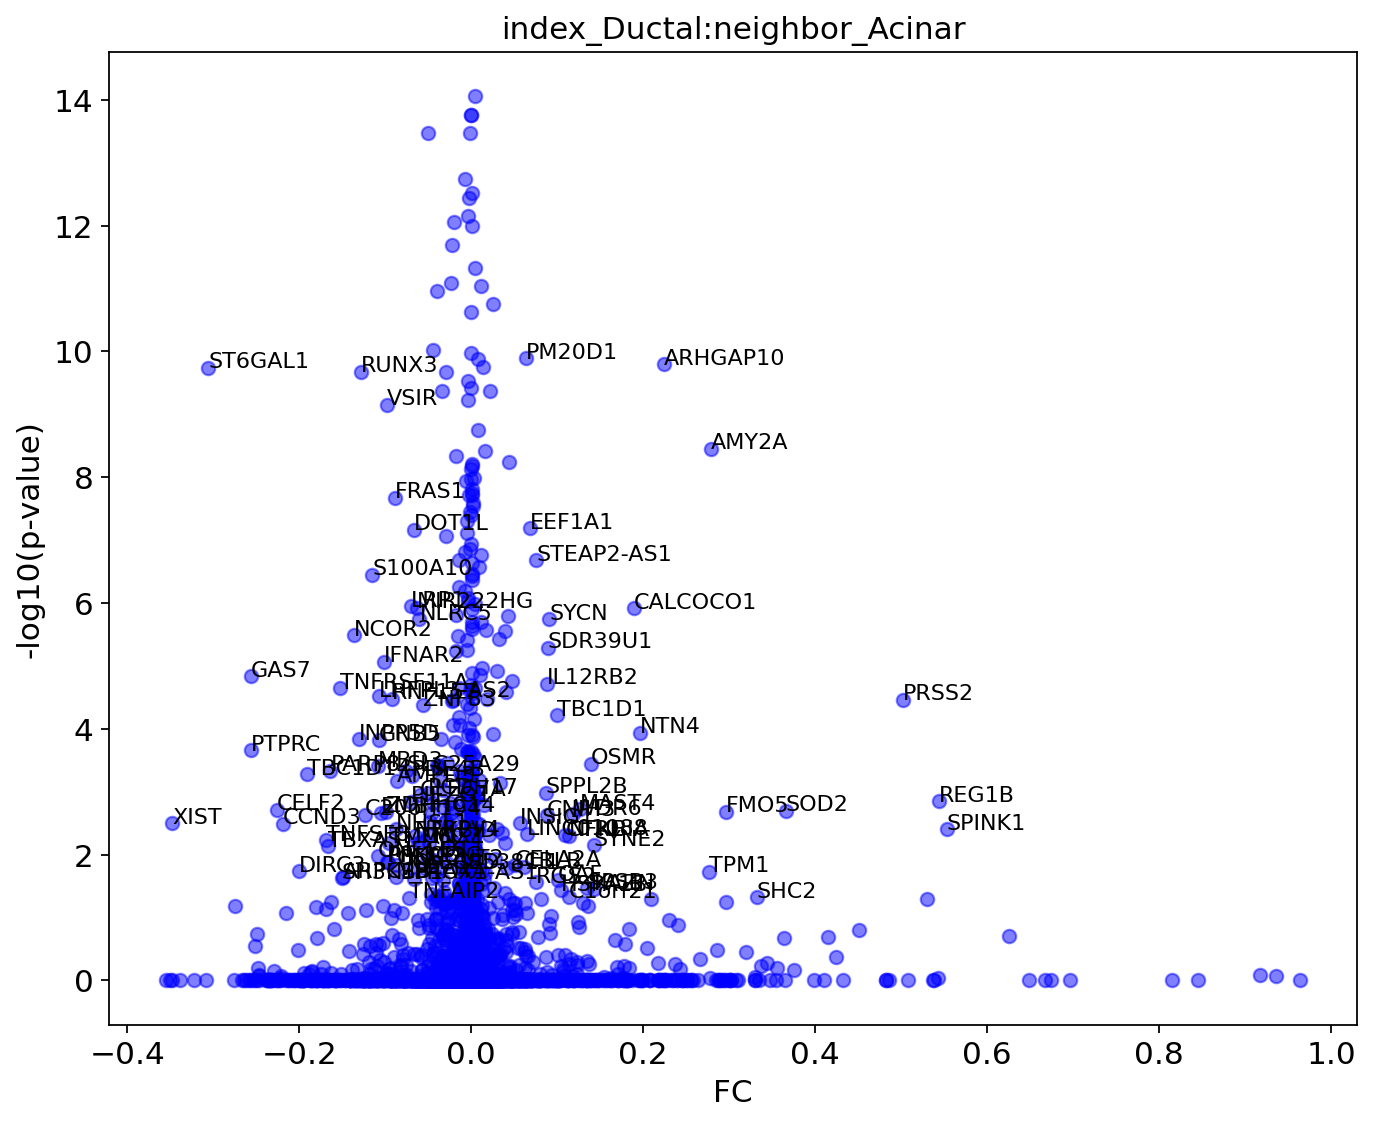

In [106]:
for c in interactions:
    data_df = {
        'log2FoldChange' : adata.varm['ncem_params'][c],
        'padj' : adata.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [45]:
adata.varm['ncem_params']

,index_Acinar,index_Alpha,index_Beta,index_Ductal,index_Endocrine,index_Endothelial,index_Fibroblasts,index_Immune,index_Mast,index_Acinar:neighbor_Acinar,...,index_Mast:neighbor_Immune,index_Acinar:neighbor_Mast,index_Alpha:neighbor_Mast,index_Beta:neighbor_Mast,index_Ductal:neighbor_Mast,index_Endocrine:neighbor_Mast,index_Endothelial:neighbor_Mast,index_Fibroblasts:neighbor_Mast,index_Immune:neighbor_Mast,index_Mast:neighbor_Mast
ACE,0.006976,0.081491,0.078028,0.012002,0.055360,0.003273,0.019413,0.007634,0.001919,-0.000481,...,-0.002522,-0.000063,0.0,0.0,0.000361,0.0,0.005292,0.000700,-0.000328,-0.002870
ACTA2,0.016611,0.028261,-0.000558,0.006327,0.073115,0.023059,0.019465,0.013733,0.041886,-0.000992,...,0.025110,0.000156,0.0,0.0,-0.002044,0.0,-0.031096,0.001486,0.018116,-0.021851
ACVRL1,0.000452,0.025647,0.000611,0.000821,0.021098,0.003962,0.015538,0.006953,0.033678,-0.000071,...,0.029199,0.000035,0.0,0.0,-0.000014,0.0,-0.013169,0.004504,0.013356,-0.020114
ADGRA2,0.003013,0.075787,0.038596,0.002102,0.067044,0.008273,0.034834,0.002312,0.036471,-0.001230,...,0.024305,-0.000111,0.0,0.0,0.000406,0.0,-0.010850,0.005448,0.016781,-0.036357
ADGRB3,0.005116,0.056590,0.057716,0.004822,0.039370,0.019340,0.037857,0.019148,0.085656,-0.000568,...,0.035655,-0.000044,0.0,0.0,0.001092,0.0,-0.035814,0.005610,0.011764,-0.069689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL049629.1,0.001822,0.004010,0.001449,0.036277,0.002321,0.001137,0.002242,0.025572,0.003234,-0.000934,...,-0.000848,-0.000038,0.0,0.0,0.001390,0.0,0.000760,0.001608,-0.000920,-0.004186
NEURL1B,0.009236,0.064279,0.008576,0.002801,0.062626,0.039731,0.039437,0.046127,0.089727,-0.004427,...,0.014370,-0.000356,0.0,0.0,-0.000347,0.0,-0.059076,0.005384,0.062536,-0.084810
RBBP8NL,0.002522,0.001321,0.005392,0.002426,0.002707,0.000830,0.001211,0.000778,0.000023,-0.000269,...,-0.000292,-0.000177,0.0,0.0,-0.000307,0.0,-0.000152,-0.000068,-0.000455,0.000449
AC009974.1,0.000131,0.002848,0.003838,0.001786,0.002308,0.000240,0.002277,0.009748,0.012850,-0.000039,...,0.005542,-0.000007,0.0,0.0,0.000119,0.0,-0.000859,0.000642,0.000053,-0.006059


In [78]:
data_df = {
    'FC' : adata.varm['ncem_params']['index_Beta:neighbor_Alpha'],
    'p_value' : adata.varm['ncem_fdr_pvals']['index_Beta:neighbor_Alpha'],
    'gene_names' : np.array(adata.varm['ncem_fdr_pvals'].index)
}

df = pd.DataFrame(data_df)
df

,FC,p_value,gene_names
ACE,0.005218,1.000000,ACE
ACTA2,0.008580,1.000000,ACTA2
ACVRL1,0.000274,1.000000,ACVRL1
ADGRA2,0.006727,1.000000,ADGRA2
ADGRB3,-0.007925,1.000000,ADGRB3
...,...,...,...
AL049629.1,0.000334,0.172893,AL049629.1
NEURL1B,0.000814,0.771207,NEURL1B
RBBP8NL,0.000571,1.000000,RBBP8NL
AC009974.1,0.001006,0.780682,AC009974.1


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


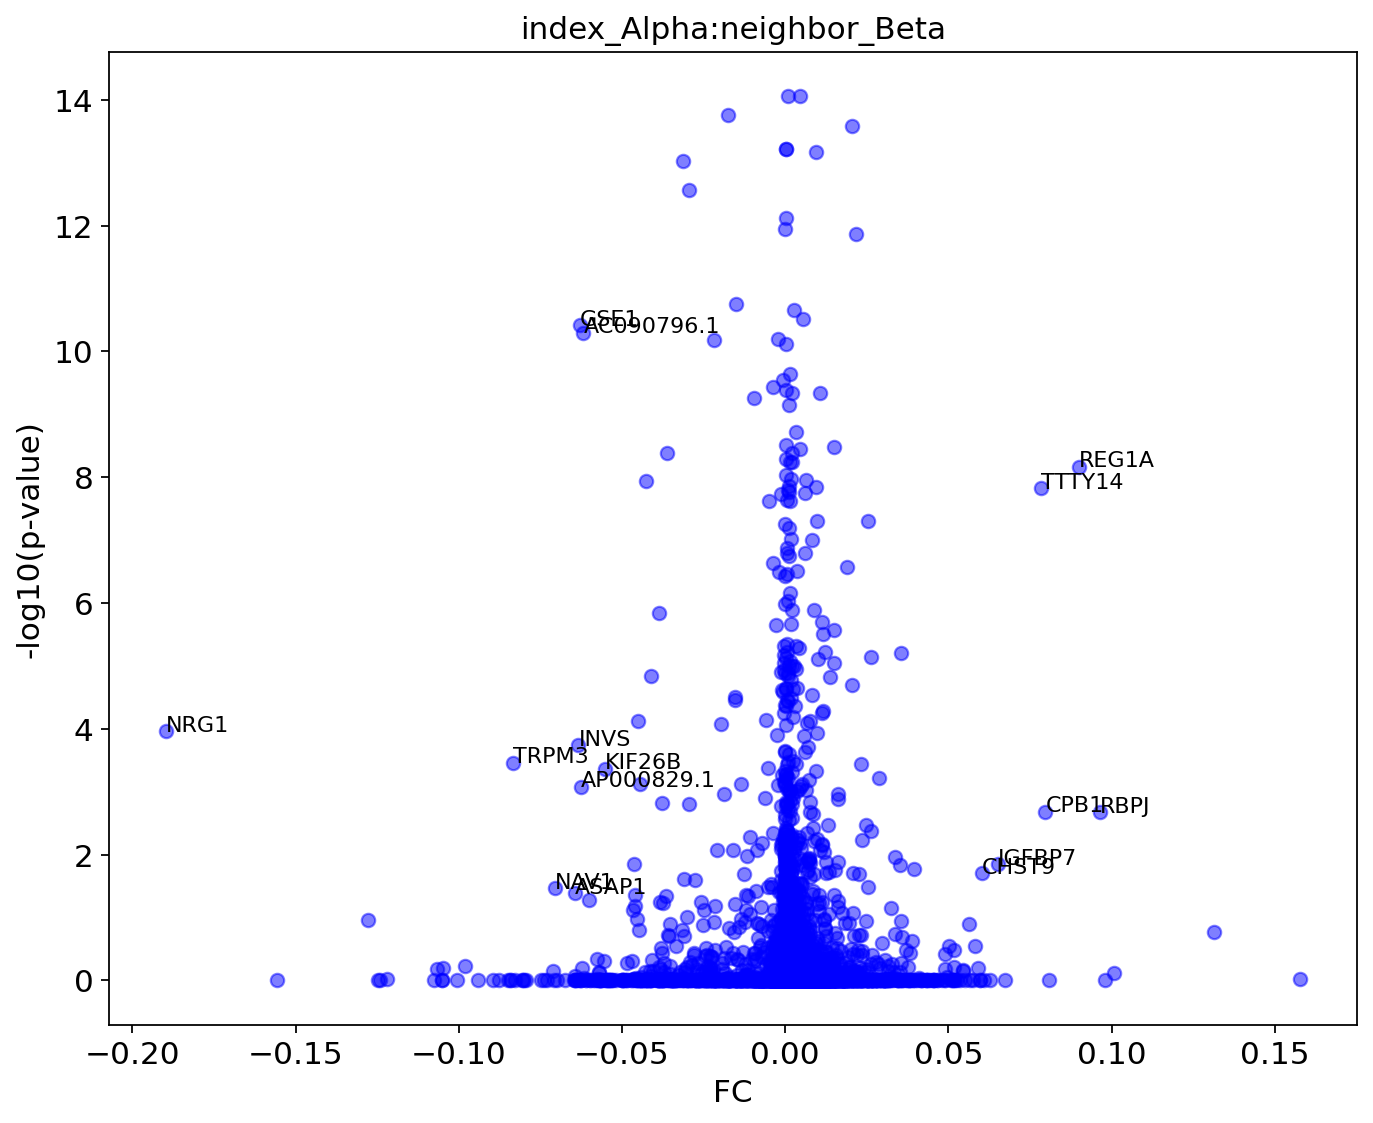

In [80]:
# Create volcano plot
#df['-log10(p_value)'] = -df['p_value'].apply(lambda x: -1 * (x**10))
df['-log10(p_value)'] = -np.log10(df['p_value'])

plt.figure(figsize=(10, 8))
plt.scatter(df['FC'], df['-log10(p_value)'], color='blue', alpha=0.5)

# Label the most significant points
threshold_logFC = 0.05  # Adjust as needed
threshold_p_value = 0.05  # Adjust as needed
significant_points = df[(abs(df['FC']) >= threshold_logFC) & (df['p_value'] <= threshold_p_value)]
for i, point in significant_points.iterrows():
    plt.text(point['FC'], point['-log10(p_value)'], point['gene_names'], fontsize=10)

# Add labels and title
plt.xlabel('FC')
plt.ylabel('-log10(p-value)')
plt.title('index_Alpha:neighbor_Beta')

# Show plot
plt.grid(False)
plt.show()

In [27]:
adata.obsm['ncem_dmat']

,index_Acinar,index_Alpha,index_Beta,index_Ductal,index_Endocrine,index_Endothelial,index_Fibroblasts,index_Immune,index_Mast,index_Acinar:neighbor_Acinar,...,index_Mast:neighbor_Immune,index_Acinar:neighbor_Mast,index_Alpha:neighbor_Mast,index_Beta:neighbor_Mast,index_Ductal:neighbor_Mast,index_Endocrine:neighbor_Mast,index_Endothelial:neighbor_Mast,index_Fibroblasts:neighbor_Mast,index_Immune:neighbor_Mast,index_Mast:neighbor_Mast
1_12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2_12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3_12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4_12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5_12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5224_12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5225_12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5226_12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5227_12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
alpha = 0.0001
np.sum(adata.varm['ncem_fdr_pvals'] < alpha) # and then sort

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


index_Acinar:neighbor_Acinar       263
index_Alpha:neighbor_Acinar        245
index_Beta:neighbor_Acinar         263
index_Ductal:neighbor_Acinar       245
index_Endocrine:neighbor_Acinar    239
                                  ... 
index_Endocrine:neighbor_Mast      260
index_Endothelial:neighbor_Mast    278
index_Fibroblasts:neighbor_Mast    241
index_Immune:neighbor_Mast         255
index_Mast:neighbor_Mast           238
Length: 81, dtype: int64

In [81]:
circular_rotated_labels

<function ncem.pl.type_couplings.circular_rotated_labels(adata, alpha, scale_edge, pvals_key: str = 'ncem_fdr_pvals', params_key: str = 'ncem_params', figsize=(10, 5), edge_type: str = 'magnitude', clip_edges: int = 0, text_space: float = 1.15)>

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


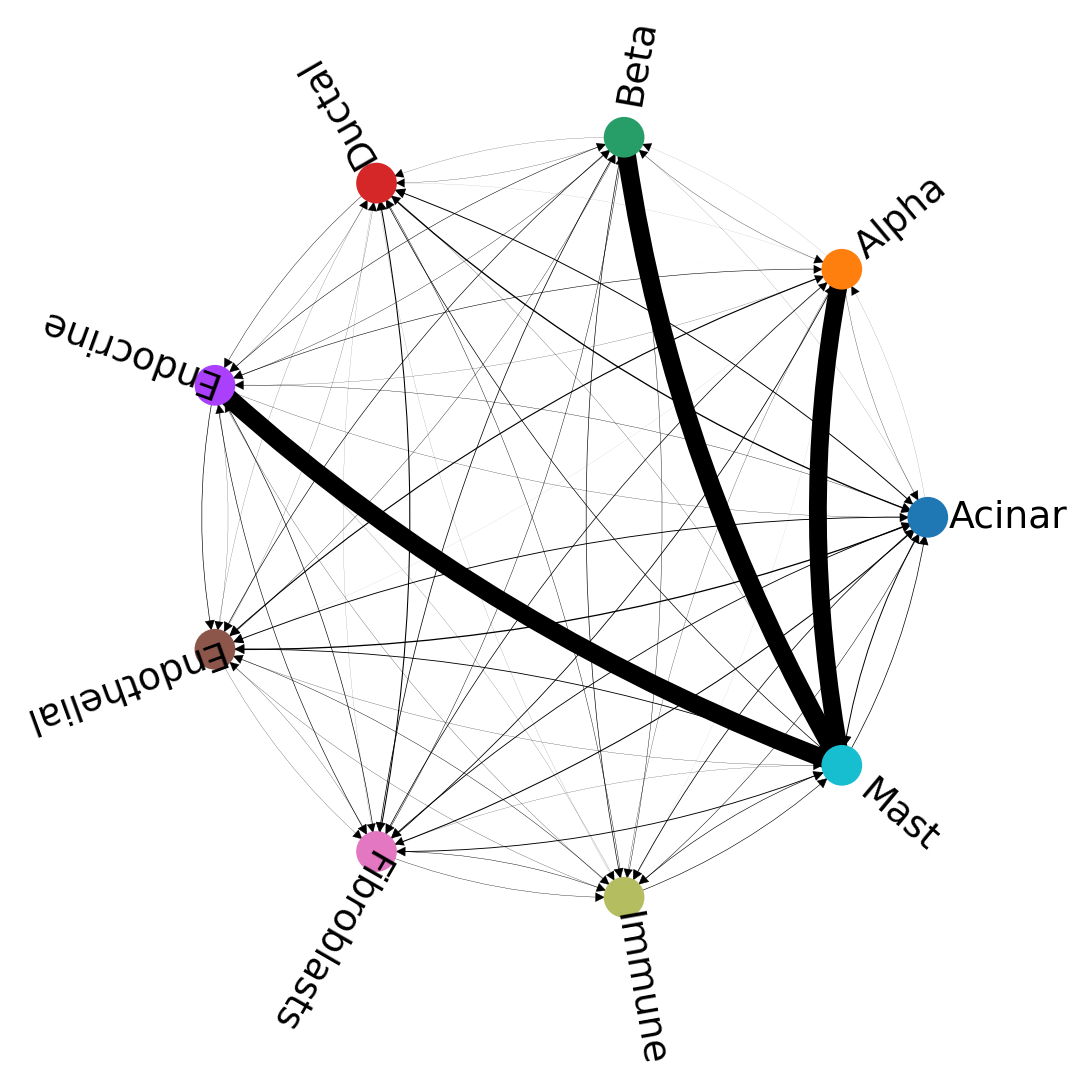

In [49]:
from ncem.pl.type_couplings import circular_rotated_labels
circular_rotated_labels(
    adata, 
    alpha=0.0001, # alpha is threshold when a p-value is considered significant (either 0.01, 0.05, 0.1)
    figsize=(7,7), 
    scale_edge=0.3, 
    params_key='ncem_params', 
    pvals_key='ncem_fdr_pvals', 
    edge_type='magnitude', # de_genes ior magnitude
    clip_edges=10 # this value is mainly for plotting reasons
)

In [36]:
adata.obs.cell_type_coarse.cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/ncem/pl/input.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x = np.log(plotdf.groupby(cluster_key).mean() + 1)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/ncem/pl/input.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y = np.log(plotdf.groupby(cluster_key).var() + 1)


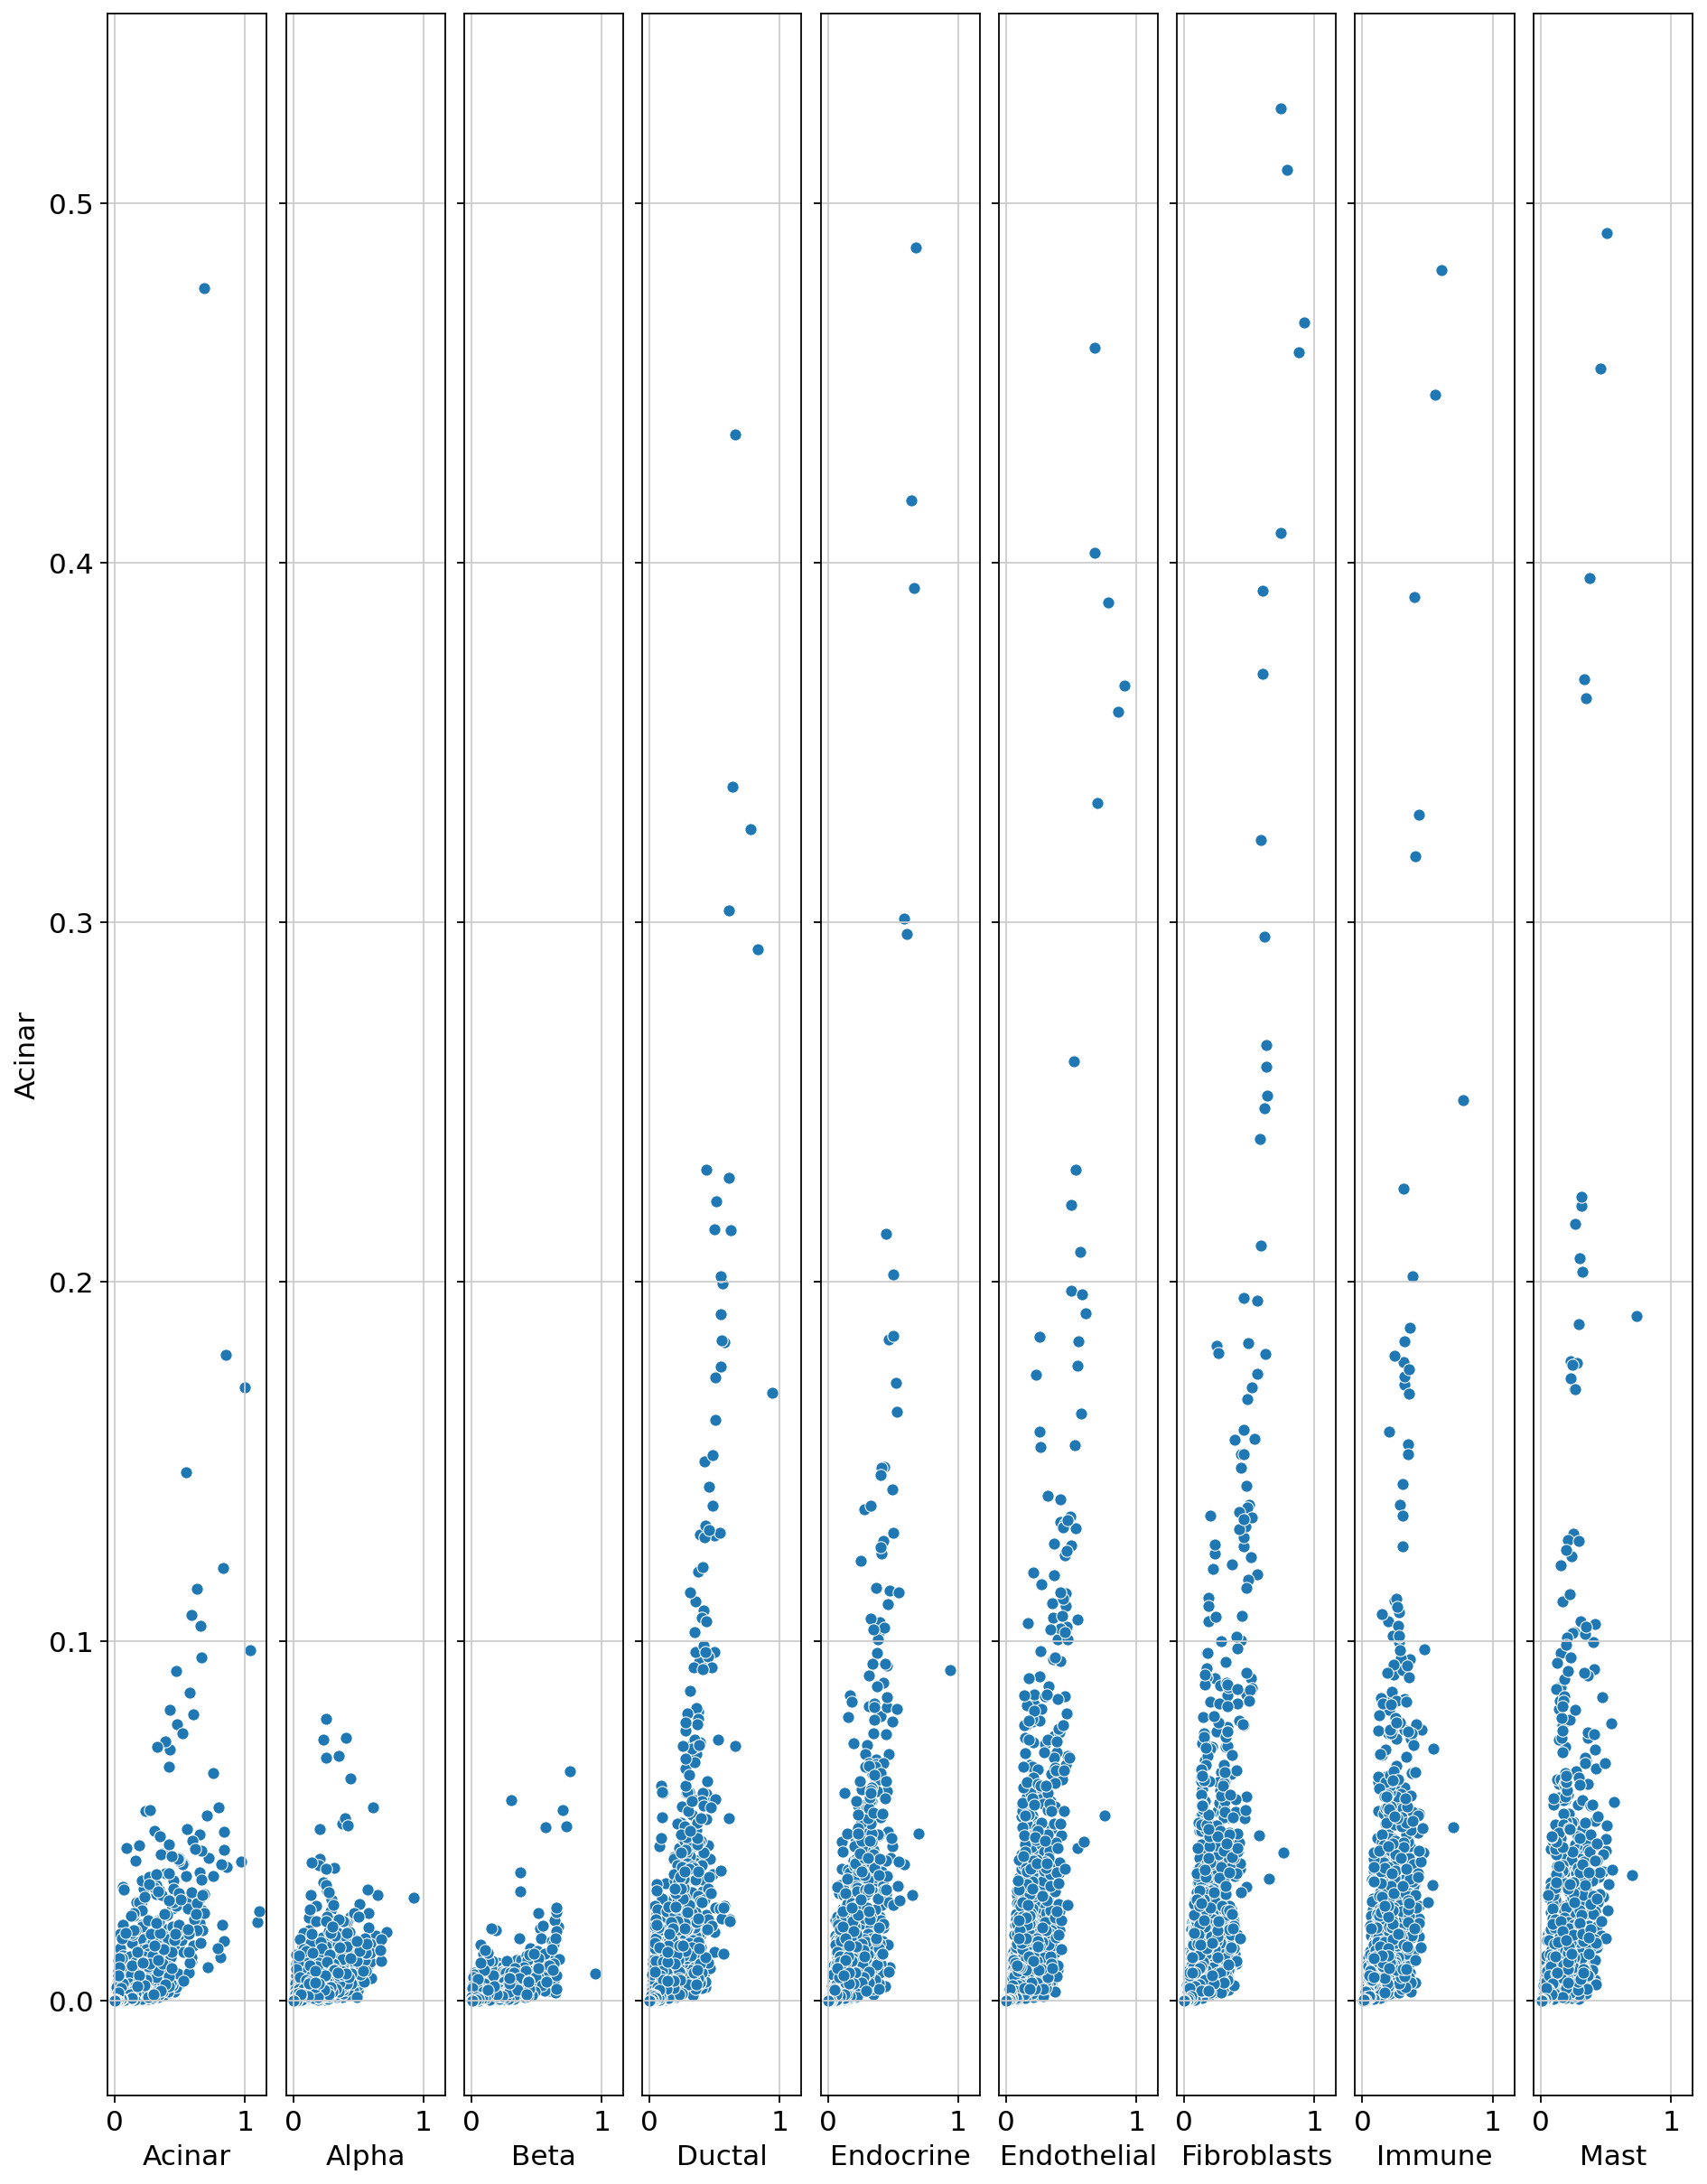

In [37]:
nc.pl.noise_structure(adata,cluster_key='cell_type_coarse',figsize=(15,15))

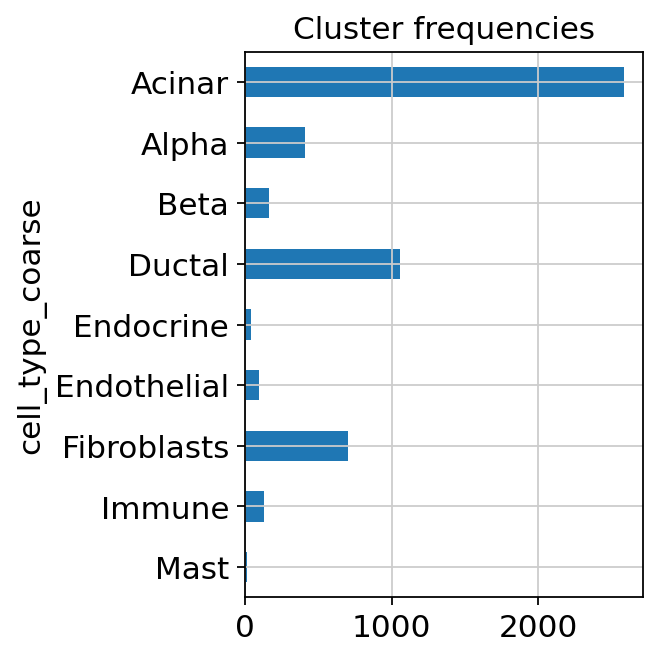

In [38]:
nc.pl.cluster_freq(adata, cluster_key='cell_type_coarse')